In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time as timer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
from xgboost import XGBClassifier
import joblib

In [3]:
stroke_data = pd.read_csv('stroke prediction.csv')

df = pd.DataFrame(stroke_data)
df.head(8)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1


In [4]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
#estimating values for the empty spaces in my data (bmi)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class bmiImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    imputer = SimpleImputer(strategy = "mean")
    X["bmi"] = imputer.fit_transform(X[["bmi"]])

    return X
  

new_bmi = bmiImputer()
new_bmi.transform(stroke_data)
stroke_data = new_bmi.transform(stroke_data)


stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
#we are checking the values present in each categorical column, as we prepare to assign numerical values into them

from sklearn.preprocessing import LabelEncoder

clean_data = stroke_data

print("gender: {}".format(clean_data['gender'].unique()))
print("ever_married: {}".format(clean_data['ever_married'].unique()))
print("work_type: {}".format(clean_data['work_type'].unique()))
print("Residence_type: {}".format(clean_data['Residence_type'].unique()))
print("smoking_status: {}".format(clean_data['smoking_status'].unique()))

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [7]:
# create encoder for each categorical variable
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [8]:
clean_data['gender'] = label_gender.fit_transform(clean_data['gender'])
clean_data['ever_married'] = label_married.fit_transform(clean_data['ever_married'])
clean_data['work_type']= label_work.fit_transform(clean_data['work_type'])
clean_data['Residence_type']= label_residence.fit_transform(clean_data['Residence_type'])
clean_data['smoking_status']= label_smoking.fit_transform(clean_data['smoking_status'])
with pd.option_context('expand_frame_repr', False):
    print(clean_data.head())

   gender   age  hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level        bmi  smoking_status  stroke
0       1  67.0             0              1             1          2               1             228.69  36.600000               1       1
1       0  61.0             0              0             1          3               0             202.21  28.893237               2       1
2       1  80.0             0              1             1          2               0             105.92  32.500000               2       1
3       0  49.0             0              0             1          2               1             171.23  34.400000               3       1
4       0  79.0             1              0             1          3               0             174.12  24.000000               2       1


In [9]:
# Display actual mappings from your saved LabelEncoder objects

print("🔸 'gender' mapping:")
for i, label in enumerate(label_gender.classes_):
    print(f"   {label} → {i}")

print("\n🔸 'ever_married' mapping:")
for i, label in enumerate(label_married.classes_):
    print(f"   {label} → {i}")

print("\n🔸 'work_type' mapping:")
for i, label in enumerate(label_work.classes_):
    print(f"   {label} → {i}")

print("\n🔸 'Residence_type' mapping:")
for i, label in enumerate(label_residence.classes_):
    print(f"   {label} → {i}")

print("\n🔸 'smoking_status' mapping:")
for i, label in enumerate(label_smoking.classes_):
    print(f"   {label} → {i}")


🔸 'gender' mapping:
   Female → 0
   Male → 1
   Other → 2

🔸 'ever_married' mapping:
   No → 0
   Yes → 1

🔸 'work_type' mapping:
   Govt_job → 0
   Never_worked → 1
   Private → 2
   Self-employed → 3
   children → 4

🔸 'Residence_type' mapping:
   Rural → 0
   Urban → 1

🔸 'smoking_status' mapping:
   Unknown → 0
   formerly smoked → 1
   never smoked → 2
   smokes → 3


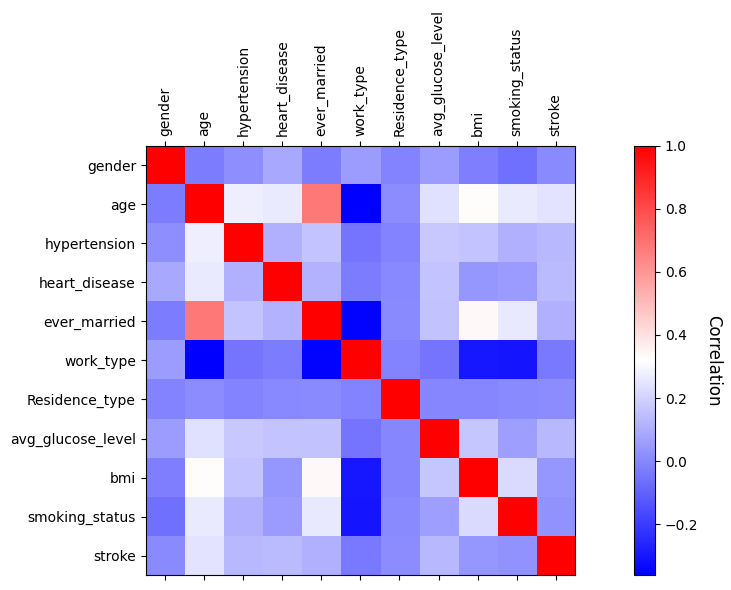

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.matshow(clean_data.corr(), cmap='bwr')
ax.set_xticks(np.arange(clean_data.shape[1]))
ax.set_yticks(np.arange(clean_data.shape[1]))
ax.set_xticklabels(clean_data.columns,rotation=90)
ax.set_yticklabels(clean_data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()


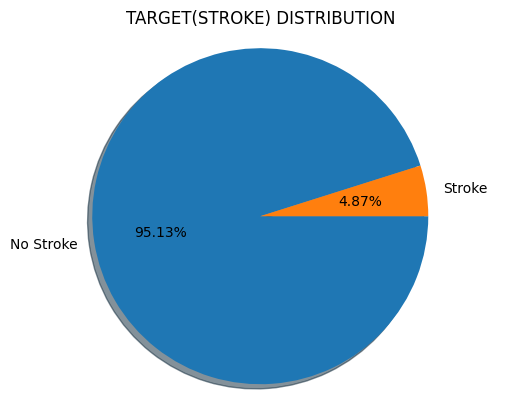

no stroke:4861 cases
stroke: 249 cases


In [11]:
#we need to check the distribution of the class target: stroke(y). In order the determine if the sample is fair enough for anaylsis.
#A pie chart is best for this type of visualization

class_occur = clean_data['stroke'].value_counts()
class_names = ['No Stroke', 'Stroke']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%', shadow=True, startangle=0, counterclock = False)
ax.axis('equal')

ax.set_title("TARGET(STROKE) DISTRIBUTION")
plt.show()
print("no stroke:{} cases".format(class_occur[0]))
print("stroke: {} cases".format(class_occur[1]))

In [12]:
#defining the feature and target, X and y respectively
X = df.drop("stroke", axis=1)
y = df["stroke"]
#the codes above are not necessary because the codes below take care of separating features(x) and target(y)


smote = SMOTE(sampling_strategy= "minority")

X,y = smote.fit_resample(clean_data.loc[:,clean_data.columns!= "stroke"], clean_data["stroke"])
print("{}".format(X.shape))
print("{}".format(y.shape))

(9722, 10)
(9722,)


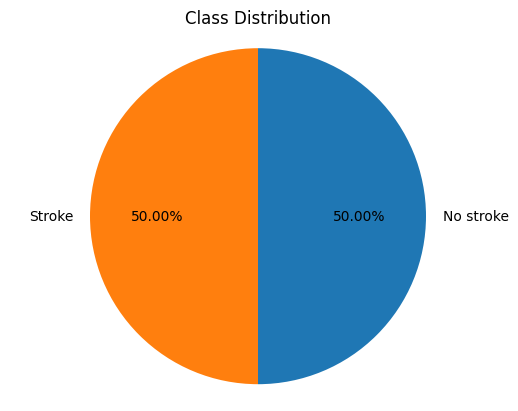

In [13]:
_, class_counts = np.unique(y, return_counts=True)

class_names = ["No stroke", "Stroke"]
fig,ax = plt.subplots()
ax.pie(class_counts, labels = class_names, autopct='%1.2f%%', startangle=90, counterclock=False)
ax.axis("equal")
ax.set_title("Class Distribution")
plt.show()

In [14]:
def split_train_valid_test(X,y,test_size= 0.1, random_state= None):
  X_train, X_test,y_train,y_test = train_test_split(X,y,test_size= test_size, random_state = random_state, stratify = y)
  X_train, X_valid, y_train, y_valid =train_test_split(X_train, y_train,test_size=test_size/(1-test_size), random_state=random_state,stratify=y_train)
  return X_train,X_valid,X_test,y_train,y_valid,y_test


X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

[train] # class 0: 3888 | # class 1: 3888
[valid] # class 0: 486 | # class 1: 487
[test]  # class 0: 487 | # class 1: 486


In [15]:
#DATA NOMINALIZATION
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

In [16]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [17]:
#PERFORMANCE METRIC
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [18]:
start = timer.time()
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_std)

Finished training within 1.60 seconds


Classification report for RF: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       487
           1       0.94      0.97      0.95       486

    accuracy                           0.95       973
   macro avg       0.95      0.95      0.95       973
weighted avg       0.95      0.95      0.95       973

Confusion matrix for RF: 
[[457  30]
 [ 17 469]]
Accuracy score for RF: 0.95
Precision score for RF: 0.94
Recall score for RF: 0.97
F1 score for RF: 0.95
Sensitivity score for RF: 0.97
Specitivity score for RF: 0.94
AUC score for RF: 0.99


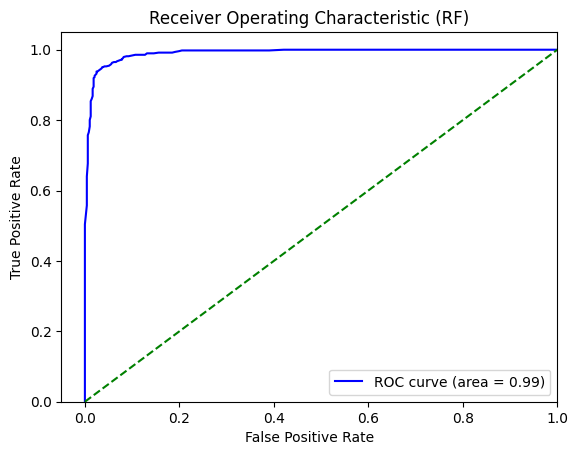

In [19]:
print("Classification report for RF: \n{}".format(classification_report(y_test,y_ranfor)))
print("Confusion matrix for RF: \n{}".format(confusion_matrix(y_test,y_ranfor)))
print("Accuracy score for RF: {:.2f}".format(accuracy_score(y_test,y_ranfor)))
# calculate precision, recall, and f1 scores
prec_ranfor = precision_score(y_test,y_ranfor)
rec_ranfor = recall_score(y_test,y_ranfor)
f1_ranfor = f1_score(y_test,y_ranfor)
print("Precision score for RF: {:.2f}".format(prec_ranfor))
print("Recall score for RF: {:.2f}".format(rec_ranfor))
print("F1 score for RF: {:.2f}".format(f1_ranfor))
# calculate sensitivity, specificity, and auc
sens_ranfor,spec_ranfor = calc_sens_spec(y_test,y_ranfor)
fpr, tpr, _ = roc_curve(y_test,  y_ranfor_prob[:,1])
auc_ranfor = roc_auc_score(y_test, y_ranfor_prob[:,1])
print("Sensitivity score for RF: {:.2f}".format(sens_ranfor))
print("Specitivity score for RF: {:.2f}".format(spec_ranfor))
print("AUC score for RF: {:.2f}".format(auc_ranfor))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (RF)')
ax.legend(loc="lower right")
plt.show()

In [20]:
#Manually testing ML Model

input = np.array([[0,    # gender: 1 = male
                          79.0, # age
                          1,    # hypertension
                          0,    # heart_disease
                          1,    # ever_married: 1 = yes
                          3,    # work_type: 1 = Private
                          0,    # Residence_type: 1 = Urban
                          174.12, # avg_glucose_level
                          24,   # bmi
                          2    # smoking_status: 1 = formerly smoked
                          ]])   

input_std = scaler.transform(input)

prediction= ranfor_model.predict(input_std)

print("Predicted stroke value",prediction[0])

Predicted stroke value 1


c:\Users\ayoba\OneDrive\Desktop\STROKE-WEBSITE-current version\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.600000,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2
2,1,80.0,0,1,1,2,0,105.92,32.500000,2
3,0,49.0,0,0,1,2,1,171.23,34.400000,3
4,0,79.0,1,0,1,3,0,174.12,24.000000,2


In [23]:
clean_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [19]:
#XGB MODEL
start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)

Finished training within 0.31 seconds


Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       487
           1       0.94      0.97      0.95       486

    accuracy                           0.95       973
   macro avg       0.95      0.95      0.95       973
weighted avg       0.95      0.95      0.95       973

Confusion matrix for XGB: 
[[457  30]
 [ 16 470]]
Accuracy score for XGB: 0.95
Precision score for XGB: 0.94
Recall score for XGB: 0.97
F1 score for XGB: 0.95
Sensitivity score for XGB: 0.97
Specitivity score for XGB: 0.94
AUC score for XGB: 0.99


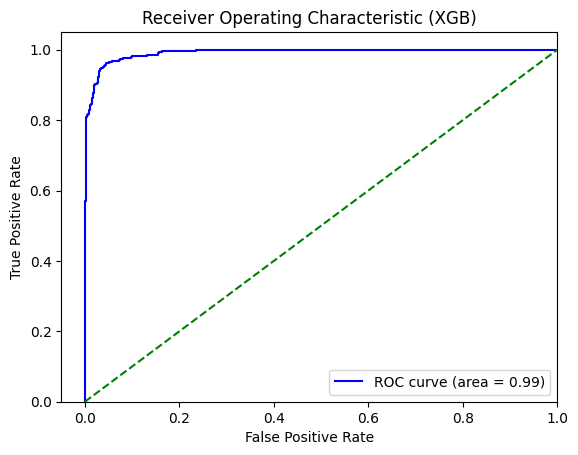

In [20]:
print("Classification report for XGB: \n{}".format(classification_report(y_test,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("Accuracy score for XGB: {:.2f}".format(accuracy_score(y_test,y_xgb)))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test,y_xgb)
rec_xgb = recall_score(y_test,y_xgb)
f1_xgb = f1_score(y_test,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
# calculate sensitivity, specificity, and auc
sens_xgb,spec_xgb = calc_sens_spec(y_test,y_xgb)
fpr, tpr, _ = roc_curve(y_test,  y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test, y_xgb_prob[:,1])
print("Sensitivity score for XGB: {:.2f}".format(sens_xgb))
print("Specitivity score for XGB: {:.2f}".format(spec_xgb))
print("AUC score for XGB: {:.2f}".format(auc_xgb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
plt.show()

In [ ]:
#saving the trained model random forest


joblib.dump(ranfor_model, "trained_model.pkl")

['trained_model.pkl']